# Appendix

## Random Forest Baseline

### 0. Load and Preview Data

In [2]:
# Import libraries
import pandas as pd

# Load the .pickle file
data = pd.read_pickle('lending_club_dataset.pickle')

# Extract the actual DataFrame (it's in the first item of the list)
df = data[0]

# Optional: extract metadata (categorical/numerical lists)
categorical_cols = data[1]
numerical_cols = data[2]

# Preview first few rows
df.head()

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,total_pymnt,last_pymnt_d,recoveries,loan_length,term_num,ret_PESS,ret_OPT,ret_INTa,ret_INTb,ret_INTc
0,40390412,5000.0,5000.0,36 months,12.39,167.01,C,< 1 year,RENT,48000.0,...,5475.14000,2015-12-01,0.0,10.973531,36,0.031676,0.103917,0.031155,0.050634,0.086751
2,40401108,17000.0,17000.0,36 months,12.39,567.82,C,1 year,RENT,53000.0,...,20452.09912,2018-03-01,0.0,37.947391,36,0.067688,0.064215,0.050574,0.066334,0.094950
3,40501689,9000.0,9000.0,36 months,14.31,308.96,C,6 years,RENT,39000.0,...,9792.56000,2015-11-01,0.0,9.987885,36,0.029354,0.105803,0.029798,0.049345,0.085622
4,40352737,14000.0,14000.0,36 months,11.99,464.94,B,6 years,RENT,44000.0,...,16592.91130,2018-01-01,0.0,36.008953,36,0.061736,0.061721,0.047093,0.063007,0.091937
5,40431323,10000.0,10000.0,60 months,19.24,260.73,E,10+ years,MORTGAGE,130000.0,...,15122.07997,2018-10-01,0.0,44.978336,60,0.102442,0.136655,0.113866,0.131897,0.164518


### 1. Define Target Variable (default)

In [4]:
# Define the binary target: 1 = defaulted, 0 = not defaulted
df['default'] = df['loan_status'].apply(
    lambda x: 1 if x in ['Charged Off', 'Default'] else 0
)

### 2. Convert 'issue_d' to Datetime and Create Features

In [6]:
from datetime import datetime

# Convert 'issue_d' to datetime
df['issue_d'] = pd.to_datetime(df['issue_d'], errors='coerce')

# Create new features from it
df['issue_year'] = df['issue_d'].dt.year
df['loan_age_months'] = (datetime.today() - df['issue_d']).dt.days // 30

# Drop original 'issue_d' to avoid issues later
df = df.drop(columns=['issue_d'])

### 3. Drop Unnecessary or Leaky Columns

In [10]:
columns_to_drop = [
    'id', 'member_id', 'loan_status',           # identifiers or target
    'recoveries', 'total_pymnt', 'last_pymnt_d', 'months_since_last_payment',  # post-loan info
    'ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb', 'ret_INTc',  # not allowed
    'predicted_prob'  # only necessary if re-running the model (best to just always include it)
]

# Drop only if the column exists (safe execution)
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

### 4. Drop Rows with Missing Values

In [12]:
# Check shape before and after dropping missing values
print("Before dropping NA:", df.shape)
df = df.dropna()
print("After dropping NA:", df.shape)

Before dropping NA: (605374, 25)
After dropping NA: (567483, 25)


### 5. One-Hot Encode Categorical Variables

In [14]:
# List of known categorical columns
categorical_cols = ['home_ownership', 'grade', 'emp_length', 'purpose', 'verification_status', 'term']

# One-hot encode with drop_first=True to avoid multicollinearity
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

### 6. Define Features and Target

In [16]:
# Define X and y
X = df.drop(columns=['default'])
y = df['default']

### Converting Object into datetime

#### (i) Converting object into datetime

In [18]:
X.dtypes[X.dtypes.apply(lambda x: x == 'object' or 'date' in str(x).lower())]

earliest_cr_line    object
dtype: object

In [20]:
from datetime import datetime

# Convert 'earliest_cr_line' to datetime

df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], errors='coerce')

# Create feature: borrower's credit history length in years
df['credit_history_years'] = datetime.today().year - df['earliest_cr_line'].dt.year

# Drop original column
df = df.drop(columns=['earliest_cr_line'])


In [22]:
X.dtypes[X.dtypes.apply(lambda x: x == 'object' or 'date' in str(x).lower())]

earliest_cr_line    object
dtype: object

#### (ii) Updating X

In [24]:
X = df.drop(columns=['default'])
y = df['default']

### 7. Train-Test Split

In [27]:
from sklearn.model_selection import train_test_split

# 80/20 split with stratify for class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

### 8. Train a Random Forest Classifier

In [29]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### 9. Evaluate the Model

Accuracy: 0.8030432522445528
AUC Score: 0.7760768973781007

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.97      0.89     89995
           1       0.58      0.17      0.26     23502

    accuracy                           0.80    113497
   macro avg       0.70      0.57      0.57    113497
weighted avg       0.77      0.80      0.76    113497



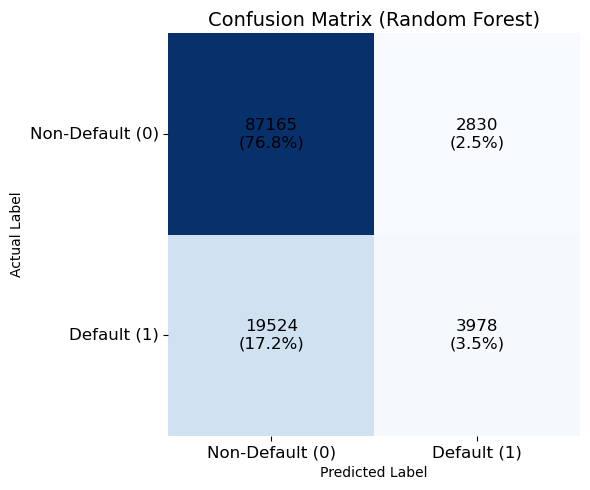

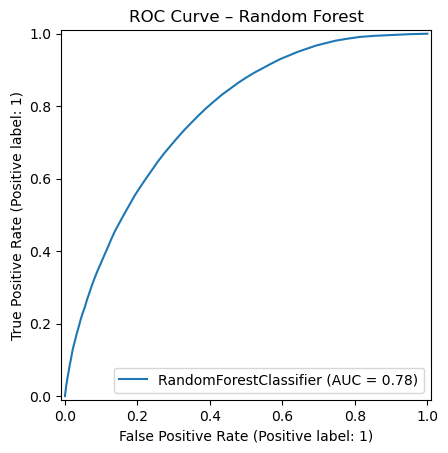

In [31]:
from sklearn.metrics import (
    accuracy_score, roc_auc_score,
    classification_report, confusion_matrix, RocCurveDisplay
)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


# Get confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_sum = np.sum(cm)
cm_percent = cm / cm_sum * 100

# Create annotation labels as "count\n(%)"
labels = np.array([
    [f"{count}\n({perc:.1f}%)" for count, perc in zip(row_counts, row_percents)]
    for row_counts, row_percents in zip(cm, cm_percent)
])

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False,
            annot_kws={"fontsize": 12, "color": "black"})

plt.title("Confusion Matrix (Random Forest)", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.xticks([0.5, 1.5], ['Non-Default (0)', 'Default (1)'], fontsize=12)
plt.yticks([0.5, 1.5], ['Non-Default (0)', 'Default (1)'], rotation=0, fontsize=12)
plt.tight_layout()
plt.show()


RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title("ROC Curve – Random Forest")
plt.show()


## Treshold Tuning for Baseline RandomForest

### 1. Predict Probabilities

In [33]:
# Predict class probabilities
y_proba = model.predict_proba(X_test)[:, 1]  # probability of default (class 1)

### 2. Apply Custom Threshold

In [35]:
# Custom threshold
threshold = 0.2

# Convert probabilities to 0 or 1
y_pred_custom = (y_proba >= threshold).astype(int)

### 3. Evaluate New Prediction

Classification report Baseline Random Forest at threshold 0.2:
Accuracy: 0.8030432522445528
AUC Score: 0.7760768973781007
              precision    recall  f1-score   support

           0       0.92      0.59      0.72     89995
           1       0.34      0.81      0.48     23502

    accuracy                           0.63    113497
   macro avg       0.63      0.70      0.60    113497
weighted avg       0.80      0.63      0.67    113497



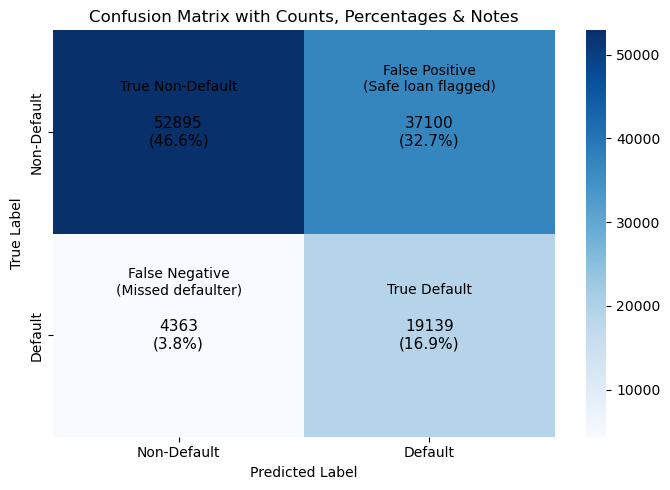

AUC Score: 0.7761


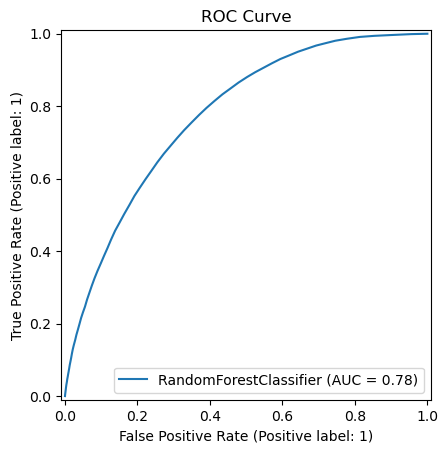

In [39]:
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------
# 1. Classification Report
# ---------------------------
print(f"Classification report Baseline Random Forest at threshold {threshold}:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred_custom))

# ---------------------------
# 2. Confusion Matrix with % and Notes
# ---------------------------
cm = confusion_matrix(y_test, y_pred_custom)
labels = ['Non-Default', 'Default']
total = np.sum(cm)

# Calculate percentages
cm_percent = cm / total * 100
annot = np.empty_like(cm).astype(str)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        percent = cm_percent[i, j]
        annot[i, j] = f"{count}\n({percent:.1f}%)"

plt.figure(figsize=(7, 5))
ax = sns.heatmap(cm, annot=annot, fmt='', cmap='Blues',
                 xticklabels=labels, yticklabels=labels,
                 annot_kws={"color": "black", "fontsize": 11})

# Add labels and title
plt.title("Confusion Matrix with Counts, Percentages & Notes")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Add in-plot explanations for each quadrant
ax.text(0.5, 0.3, 'True Non-Default', color='black', ha='center', fontsize=10)
ax.text(1.5, 0.3, 'False Positive\n(Safe loan flagged)', color='black', ha='center', fontsize=10)
ax.text(0.5, 1.3, 'False Negative\n(Missed defaulter)', color='black', ha='center', fontsize=10)
ax.text(1.5, 1.3, 'True Default', color='black', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# ---------------------------
# 3. AUC Score
# ---------------------------
print(f"AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# ---------------------------
# 4. ROC Curve
# ---------------------------
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title("ROC Curve")
plt.show()


### 4. Plot Metrics for Multiple Thresholds

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


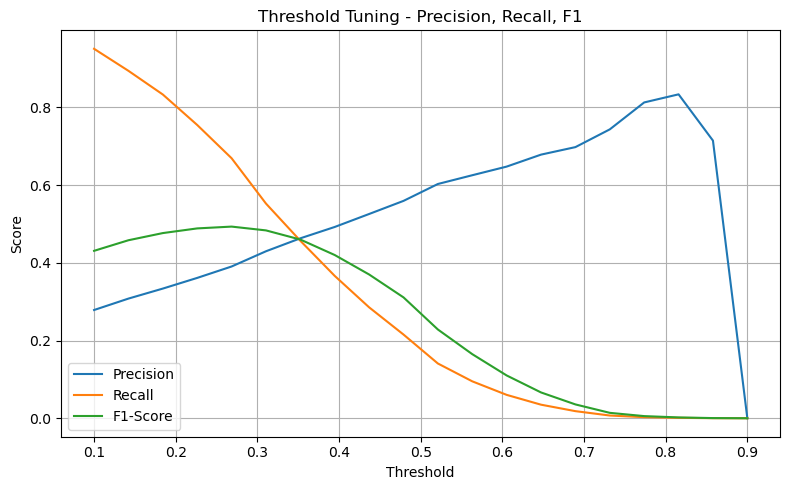

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.linspace(0.1, 0.9, 20)
precision = []
recall = []
f1 = []

for t in thresholds:
    y_t = (y_proba >= t).astype(int)
    precision.append(precision_score(y_test, y_t))
    recall.append(recall_score(y_test, y_t))
    f1.append(f1_score(y_test, y_t))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision, label="Precision")
plt.plot(thresholds, recall, label="Recall")
plt.plot(thresholds, f1, label="F1-Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Tuning - Precision, Recall, F1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<div style="line-height: 1.6;">
To enhance the model’s ability to detect loan defaults, we performed threshold tuning by analyzing the trade-off between precision, recall, and F1-score across a range of classification thresholds. While the default threshold of 0.5 yielded high precision, it resulted in very low recall — meaning the model failed to identify a large number of actual defaults, which is undesirable for risk management purposes.
</div>
<br>
<div style="line-height: 1.6;">
As illustrated in the Precision-Recall-F1 plot, the F1-score peaks around a threshold of 0.25–0.3, suggesting an optimal balance between catching defaulters and minimizing false alarms. However, to further prioritize the identification of defaults, we intentionally selected a lower threshold of 0.2. This more conservative strategy increases the recall rate, allowing the model to capture more actual defaulters — even at the cost of reduced precision.
</div>
<br>
<div style="line-height: 1.6;">
By lowering the threshold to 0.2, we accept a higher number of false positives in exchange for better coverage of risky loans. This approach aligns with the goal of minimizing missed defaulters, especially in financial settings where failing to flag high-risk loans may carry higher costs than mistakenly flagging safe ones.

## Random Forest Class Weighting

### Dropping predicted_prob (in case of rerunning the model)

In [49]:
columns_to_drop = [
    'id', 'member_id', 'loan_status',           # identifiers or target
    'recoveries', 'total_pymnt', 'last_pymnt_d', 'months_since_last_payment',  # post-loan info
    'ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb', 'ret_INTc',  # not allowed
    'predicted_prob'  # if it exists from earlier predictions
]

# Drop only if the column exists (safe execution)
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

### 1. Compute Class Weights

In [51]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Automatically calculate weights for class 0 and 1
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Create dictionary format for the classifier
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print("Class Weights:", class_weight_dict)


Class Weights: {0: 0.6305728945299587, 1: 2.414639335368643}


### 2. Train the Random Forest with class_weight

In [53]:
from sklearn.ensemble import RandomForestClassifier

model_weighted = RandomForestClassifier(
    random_state=42,
    class_weight=class_weight_dict
)

model_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.6305728945299587,
                                     1: 2.414639335368643},
                       random_state=42)

### 3. Evaluate the Model

Evaluation for Class-Weighted Model
Accuracy: 0.8020916852427817
AUC Score: 0.779043510671876

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.97      0.89     89995
           1       0.59      0.15      0.24     23502

    accuracy                           0.80    113497
   macro avg       0.70      0.56      0.56    113497
weighted avg       0.77      0.80      0.75    113497



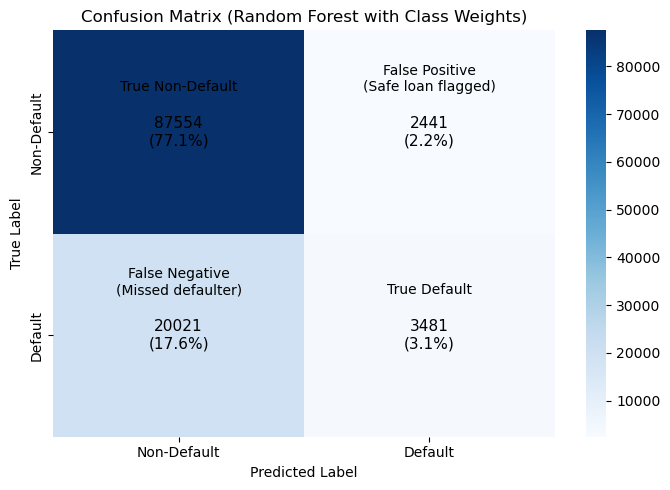

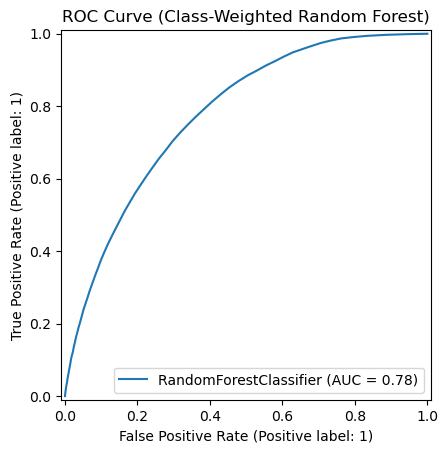

In [55]:
# Evaluation for Class-Weighted Random Forest Model

from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    RocCurveDisplay, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# -----------------------------------------------------
# Use the class-weighted model (important!)
# -----------------------------------------------------
y_pred = model_weighted.predict(X_test)
y_prob = model_weighted.predict_proba(X_test)[:, 1]

# -----------------------------------------------------
# Evaluation Metrics
# -----------------------------------------------------
print("Evaluation for Class-Weighted Model")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# -----------------------------------------------------
# Confusion Matrix (with Percentages and Annotations)
# -----------------------------------------------------
cm = confusion_matrix(y_test, y_pred)
labels = ['Non-Default', 'Default']
total = cm.sum()

# Add counts + percentages in the cells
cm_percent = cm / total * 100
annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        percent = cm_percent[i, j]
        annot[i, j] = f"{count}\n({percent:.1f}%)"

plt.figure(figsize=(7, 5))
ax = sns.heatmap(cm, annot=annot, fmt='', cmap='Blues',
                 xticklabels=labels, yticklabels=labels,
                 annot_kws={"color": "black", "fontsize": 11})

plt.title("Confusion Matrix (Random Forest with Class Weights)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Quadrant explanations
ax.text(0.5, 0.3, 'True Non-Default', color='black', ha='center', fontsize=10)
ax.text(1.5, 0.3, 'False Positive\n(Safe loan flagged)', color='black', ha='center', fontsize=10)
ax.text(0.5, 1.3, 'False Negative\n(Missed defaulter)', color='black', ha='center', fontsize=10)
ax.text(1.5, 1.3, 'True Default', color='black', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# -----------------------------------------------------
# ROC Curve for Class-Weighted Model
# -----------------------------------------------------
RocCurveDisplay.from_estimator(model_weighted, X_test, y_test)
plt.title("ROC Curve (Class-Weighted Random Forest)")
plt.show()

## Treshold Tuning for Class Weighted Model

In [57]:
columns_to_drop = [
    'id', 'member_id', 'loan_status',           # identifiers or target
    'recoveries', 'total_pymnt', 'last_pymnt_d', 'months_since_last_payment',  # post-loan info
    'ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb', 'ret_INTc',  # not allowed
    'predicted_prob'  # only necessary if re-running the model (best to just always include it)
]

# Drop only if the column exists (safe execution)
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

### 1. Predict Probabilities

In [59]:
# Predict class probabilities
y_proba = model_weighted.predict_proba(X_test)[:, 1]  # probability of default (class 1)

### 2. Apply Custom Threshold

In [61]:
# Custom threshold
threshold = 0.2

# Convert probabilities to 0 or 1
y_pred_custom = (y_proba >= threshold).astype(int)

### 3. Evaluate New Prediction

Classification report Class Weighted Model at threshold 0.2:
Accuracy: 0.8020916852427817
AUC Score: 0.779043510671876
              precision    recall  f1-score   support

           0       0.92      0.62      0.74     89995
           1       0.35      0.79      0.49     23502

    accuracy                           0.65    113497
   macro avg       0.63      0.70      0.61    113497
weighted avg       0.80      0.65      0.69    113497



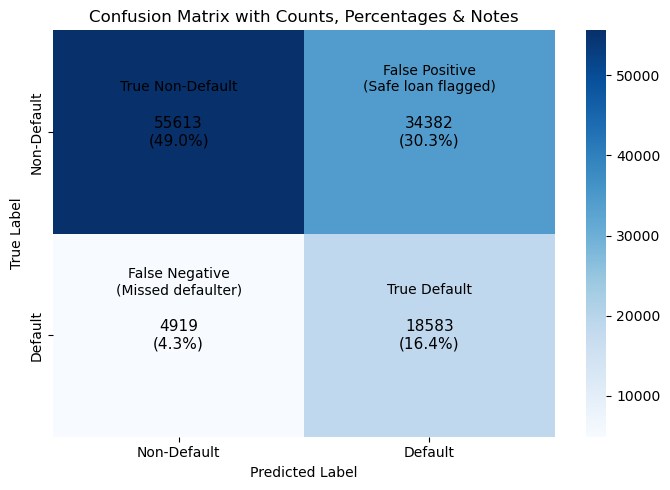

AUC Score: 0.7790


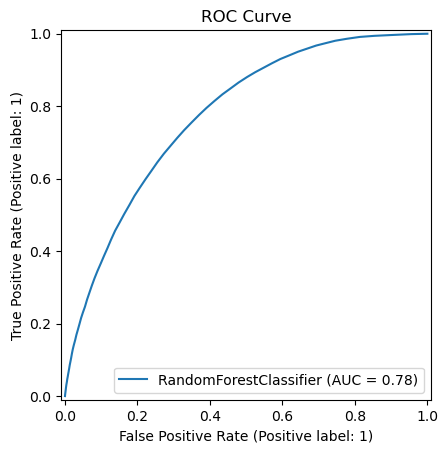

In [63]:
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------
# 1. Classification Report
# ---------------------------
print(f"Classification report Class Weighted Model at threshold {threshold}:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred_custom))

# ---------------------------
# 2. Confusion Matrix with % and Notes
# ---------------------------
cm = confusion_matrix(y_test, y_pred_custom)
labels = ['Non-Default', 'Default']
total = np.sum(cm)

# Calculate percentages
cm_percent = cm / total * 100
annot = np.empty_like(cm).astype(str)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        percent = cm_percent[i, j]
        annot[i, j] = f"{count}\n({percent:.1f}%)"

plt.figure(figsize=(7, 5))
ax = sns.heatmap(cm, annot=annot, fmt='', cmap='Blues',
                 xticklabels=labels, yticklabels=labels,
                 annot_kws={"color": "black", "fontsize": 11})

# Add labels and title
plt.title("Confusion Matrix with Counts, Percentages & Notes")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Add in-plot explanations for each quadrant
ax.text(0.5, 0.3, 'True Non-Default', color='black', ha='center', fontsize=10)
ax.text(1.5, 0.3, 'False Positive\n(Safe loan flagged)', color='black', ha='center', fontsize=10)
ax.text(0.5, 1.3, 'False Negative\n(Missed defaulter)', color='black', ha='center', fontsize=10)
ax.text(1.5, 1.3, 'True Default', color='black', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# ---------------------------
# 3. AUC Score
# ---------------------------
print(f"AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# ---------------------------
# 4. ROC Curve
# ---------------------------
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title("ROC Curve")
plt.show()


### 4. Plot Metrics for Multiple Thresholds

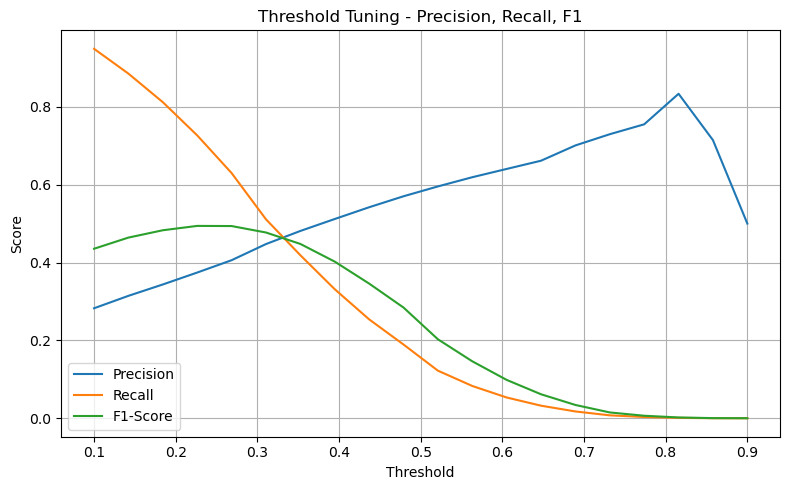

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.linspace(0.1, 0.9, 20)
precision = []
recall = []
f1 = []

for t in thresholds:
    y_t = (y_proba >= t).astype(int)
    precision.append(precision_score(y_test, y_t))
    recall.append(recall_score(y_test, y_t))
    f1.append(f1_score(y_test, y_t))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision, label="Precision")
plt.plot(thresholds, recall, label="Recall")
plt.plot(thresholds, f1, label="F1-Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Tuning - Precision, Recall, F1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<div style="line-height: 1.6;">
To enhance the model’s ability to detect loan defaults, we performed threshold tuning by analyzing the trade-off between precision, recall, and F1-score across a range of classification thresholds. While the default threshold of 0.5 yielded high precision, it resulted in very low recall — meaning the model failed to identify a large number of actual defaults, which is undesirable for risk management purposes.
</div>
<br>
<div style="line-height: 1.6;">
As illustrated in the Precision-Recall-F1 plot, the F1-score peaks around a threshold of 0.25–0.3, suggesting an optimal balance between catching defaulters and minimizing false alarms. However, to further prioritize the identification of defaults, we intentionally selected a lower threshold of 0.2. This more conservative strategy increases the recall rate, allowing the model to capture more actual defaulters — even at the cost of reduced precision.
</div>
<br>
<div style="line-height: 1.6;">
By lowering the threshold to 0.2, we accept a higher number of false positives in exchange for better coverage of risky loans. This approach aligns with the goal of minimizing missed defaulters, especially in financial settings where failing to flag high-risk loans may carry higher costs than mistakenly flagging safe ones.